<h1> <font color='red'><b> Text-To-Speech with Transformers</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='blue'><b> **1. Install and import required libraries**

**Install Speechbrain**

In [3]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
!pip install --upgrade --no-cache-dir gdown

In [5]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00


In [6]:
import os
import json
import re
import random
import torchaudio
import csv
import torch
import tqdm
from unidecode import unidecode
import speechbrain as sb
from speechbrain.inference.text import GraphemeToPhoneme
from hyperpyyaml import load_hyperpyyaml
from pathlib import Path
from speechbrain.utils.data_utils import get_all_files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

# <font color='blue'><b> **2. Dataset**

**The LJSPeech dataset can be downloaded from here** - [link](https://keithito.com/LJ-Speech-Dataset/)





In [7]:
!gdown 1XrX1ApTj1XZJ87vowhZmpf-FWA5gPDTC

Downloading...
From (original): https://drive.google.com/uc?id=1XrX1ApTj1XZJ87vowhZmpf-FWA5gPDTC
From (redirected): https://drive.google.com/uc?id=1XrX1ApTj1XZJ87vowhZmpf-FWA5gPDTC&confirm=t&uuid=34fa95ff-cbbf-42cc-8443-548aa4c5233f
To: /content/LJSpeech-1.1.tar.bz2
100% 2.75G/2.75G [01:23<00:00, 33.1MB/s]


**Uncompress the data**

In [8]:
file_path = '/content/LJSpeech-1.1.tar.bz2'
extract_path = '/content/data'

# Use the !tar command to extract the file
!mkdir -p "$extract_path"
!tar -xjf "$file_path" -C "$extract_path"

## **Data Preparation**

In [ ]:
def custom_clean(text):
    """
    Uses custom criteria to clean text.

    Parameters
    ----------
    text : str
        Input text to be cleaned.
    model_name : str
        Name of the model to determine cleaning criteria.

    Returns
    -------
    text : str
        Cleaned text.

    Notes
    -----
    This function cleans the input text based on custom criteria, including expanding common abbreviations
    to their full forms.

    Examples
    --------
    >>> custom_clean("Mr. Smith works at XYZ Ltd.", model_name="english")
    'mister smith works at xyz limited.'
    >>> custom_clean("Dr. Brown, Jr. is an honorable man.", model_name="english")
    'doctor brown, junior is an honorable man.'

    This code sample is taken from SPeechbrain Tacotron2 implementation
    """

    _abbreviations = [
        (re.compile("\\b%s\\." % x[0], re.IGNORECASE), x[1])
        for x in [
            ("mrs", "missus"),
            ("mr", "mister"),
            ("dr", "doctor"),
            ("st", "saint"),
            ("co", "company"),
            ("jr", "junior"),
            ("maj", "major"),
            ("gen", "general"),
            ("drs", "doctors"),
            ("rev", "reverend"),
            ("lt", "lieutenant"),
            ("hon", "honorable"),
            ("sgt", "sergeant"),
            ("capt", "captain"),
            ("esq", "esquire"),
            ("ltd", "limited"),
            ("col", "colonel"),
            ("ft", "fort"),
        ]
    ]
    text = unidecode(text.lower())
    text = re.sub(" +", " ", text)

    for regex, replacement in _abbreviations:
        text = re.sub(regex, replacement, text)
    return text

In [ ]:
def split_sets(csv_file_name, splits, split_ratio):
    """Randomly splits the wav list into training, validation, and test lists.
    Note that a better approach is to make sure that all the classes have the
    same proportion of samples for each session.

    Parameters
    ---------
    csv_file_name : str
        The path to the file  containing the data.
    splits : list
        The list of the selected splits, e.g., ["train", "valid", "test"].
    split_ratio : list
        List of split_ratio=[80, 10, 10] will assign 80% of the sentences
        to training, 10% for validation, and 10% for test.

    Returns
    -------
    dictionary containing train, valid, and test splits.


    Examples
    --------
    >>> csv_file_name = "data.csv"
    >>> splits = ["train", "valid", "test"]
    >>> split_ratio = [80, 10, 10]
    >>> split_sets(csv_file_name, splits, split_ratio)
    ({'train': [indices_train], 'valid': [indices_valid], 'test': [indices_test]}, meta_csv)

    This code sample is taken from SPeechbrain Tacotron2 implementation
    """

    # Read CSV file
    csv_reader = csv.reader(
        open(csv_file_name), delimiter="|", quoting=csv.QUOTE_NONE
    )

    meta_csv = list(csv_reader)

    # Group indices by session
    index_for_sessions = []
    session_id_start = "LJ001"
    index_this_session = []
    for i in range(len(meta_csv)):
        session_id = meta_csv[i][0].split("-")[0]
        if session_id == session_id_start:
            index_this_session.append(i)
            if i == len(meta_csv) - 1:
                index_for_sessions.append(index_this_session)
        else:
            index_for_sessions.append(index_this_session)
            session_id_start = session_id
            index_this_session = [i]

    # Calculate session lengths
    session_len = [len(session) for session in index_for_sessions]

    # Initialize data split dictionary
    data_split = {}
    # Split data based on ratios
    for i, split in enumerate(splits):
        data_split[split] = []
        for j in range(len(index_for_sessions)):
            if split == "train":
                random.shuffle(index_for_sessions[j])
                n_snts = int(session_len[j] * split_ratio[i] / sum(split_ratio))
                data_split[split].extend(index_for_sessions[j][0:n_snts])
                del index_for_sessions[j][0:n_snts]
            if split == "valid":
                if "test" in splits:
                    random.shuffle(index_for_sessions[j])
                    n_snts = int(
                        session_len[j] * split_ratio[i] / sum(split_ratio)
                    )
                    data_split[split].extend(index_for_sessions[j][0:n_snts])
                    del index_for_sessions[j][0:n_snts]
                else:
                    data_split[split].extend(index_for_sessions[j])
            if split == "test":
                data_split[split].extend(index_for_sessions[j])

    return data_split, meta_csv

In [ ]:
def prepare_json(csv_reader, json_file, wavs_folder,
                 seg_lst, g2p, use_custom_cleaner=False):
    """
    Creates json file given a list of indexes.

    Arguments
    ---------
    csv_reader : str
        Input csv file reader - LJspeech metadata
    json_file : str
        Output json path
    wavs_folder : str
        LJspeech wavs folder
    seg_lst : list
        The list of json indexes of a given data split
    g2p : object
        The grapheme-to-phoneme conversion object
    use_custom_cleaner : bool, optional
        If True, uses custom cleaner defined


    Returns
    -------
    None

    Notes
    -----
    The JSON file will contain information about each audio segment specified by
    the provided indexes, including unique identifiers,
    paths to WAV files, segment labels, durations, and phonetic representations.

    Example
    -------
    # Import necessary modules
    import torchaudio
    import tqdm
    import os
    import json

    # Define paths and parameters
    csv_reader = "/path/to/metadata.csv"
    json_file = "/path/to/output.json"
    wavs_folder = "/path/to/audio/wavs"
    seg_lst = [0, 1, 2, 3, 4]  # Indexes of segments to include
    g2p = YourGraphemeToPhonemeTool()  # Initialize or import your G2P tool

    # Create the JSON file
    prepare_json(csv_reader, json_file, wavs_folder, seg_lst, g2p, use_custom_cleaner=True)
    """

    json_dict = {}

    for index in tqdm.tqdm(seg_lst):
        # data preparation
        id = list(csv_reader)[index][0]
        wav_file = os.path.join(wavs_folder, f"{id}.wav")

        info = torchaudio.info(wav_file)
        duration = info.num_frames / info.sample_rate

        label = list(csv_reader)[index][2]
        if use_custom_cleaner:
            label = custom_clean(label).upper()

        phoneme = g2p.g2p([label])[0]

        json_dict[id] = {
            "uttid": id,
            "wav": wav_file,
            "label": label,
            "length": duration,
            "phoneme": phoneme,
           }

    # Writing the dictionary to the json file
    with open(json_file, mode="w") as json_f:
        json.dump(json_dict, json_f, indent=2)

    # logger.info(f"{json_file} successfully created!")


In [ ]:
data_folder='/content/data/LJSpeech-1.1'
wavs_folder = '/content/data/LJSpeech-1.1/wavs'
file_name = 'metadata.csv'
csv_file_name = os.path.join(data_folder, file_name)

splits=["train", "valid", "test"]
split_ratio=[80, 10, 10]

# perform random split fo data for train, valid and test
data_split_dicts, csv_reader = split_sets(csv_file_name, splits, split_ratio)

g2p = GraphemeToPhoneme.from_hparams("speechbrain/soundchoice-g2p",
                                     run_opts={"device": device})


# now generate the JSON files as per the previous splits defined
prepare_json(csv_reader, 'train_data.json', wavs_folder, data_split_dicts["train"], g2p, use_custom_cleaner=True)
prepare_json(csv_reader, 'valid_data.json', wavs_folder, data_split_dicts["valid"], g2p, use_custom_cleaner=True)
prepare_json(csv_reader, 'test_data.json', wavs_folder, data_split_dicts["test"], g2p, use_custom_cleaner=True)

hyperparams.yaml:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/129M [00:00<?, ?B/s]

ctc_lin.ckpt:   0%|          | 0.00/177k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 1356/1356 [59:16<00:00,  2.62s/it]


In [ ]:
from google.colab import files

# Download the file to your local device
files.download("/content/train_data.json")
files.download("/content/test_data.json")
files.download("/content/valid_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# <font color='blue'><b> **3. Import Custom Modules**

**Import the required custom classes**

In [14]:
!cp -r /content/drive/MyDrive/TTS/utils/* /content/

In [15]:
# import importlib
from CNNPrenet import CNNPrenet
from CNNDecoderPrenet import CNNDecoderPrenet
from  ScaledPositionalEncoding import ScaledPositionalEncoding
from MelSpectrogram import MelSpectrogram
from TextMelCollate import TextMelCollate

# <font color='blue'><b> **4. Hyperparameter file**

In [16]:
%%file hparams.yaml

############################################################################
# Model: TTS with attention-based mechanism
# Tokens: g2p + possitional embeddings
# losses: MSE & BCE
# Training: LJSpeech
# ############################################################################


###################################
# Experiment Parameters and setup #
###################################
seed: 1234
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Folder set up
output_folder: !ref ./results/tts/<seed> # !ref .\\results\\tts\\<seed> for windows system
save_folder: !ref <output_folder>/save #!ref <output_folder>\\save for windows system
train_log: !ref <output_folder>/train_log.txt # !ref <output_folder>\\train_log.txt for windows system
epochs: 80
keep_checkpoint_interval: 2
sorting: descending


#################################
# Data files and pre-processing #
#################################
data_folder: !PLACEHOLDER # e.g, /content/data/LJSpeech-1.1

train_json: train_data.json
valid_json: valid_data.json
test_json: test_data.json


################################
# Audio Parameters             #
################################
sample_rate: 22050
hop_length: 256
win_length: 1024
n_mel_channels: 80
n_fft: 1024
mel_fmin: 0.0
mel_fmax: 8000.0
power: 1
norm: "slaney"
mel_scale: "slaney"
dynamic_range_compression: True
mel_normalized: False
min_max_energy_norm: True
min_f0: 65  #(torchaudio pyin values)
max_f0: 2093 #(torchaudio pyin values)

################################
# Optimization Hyperparameters #
################################
learning_rate: 0.00001
weight_decay: 0.000006
max_grad_norm: 1.0
batch_size: 8 #minimum 2
mask_padding: True


################################
# Model Parameters and model   #
################################
# Input parameters
lexicon:
    - AA
    - AE
    - AH
    - AO
    - AW
    - AY
    - B
    - CH
    - D
    - DH
    - EH
    - ER
    - EY
    - F
    - G
    - HH
    - IH
    - IY
    - JH
    - K
    - L
    - M
    - N
    - NG
    - OW
    - OY
    - P
    - R
    - S
    - SH
    - T
    - TH
    - UH
    - UW
    - V
    - W
    - Y
    - Z
    - ZH

input_encoder: !new:speechbrain.dataio.encoder.TextEncoder


#####################################
# Data Loaders for Batch processing #
#####################################

train_dataloader_opts:
  batch_size: !ref <batch_size>
  drop_last: False  #True #False
  shuffle: True
  collate_fn: !new:TextMelCollate.TextMelCollate

valid_dataloader_opts:
  batch_size: !ref <batch_size>
  shuffle: False
  collate_fn: !new:TextMelCollate.TextMelCollate

test_dataloader_opts:
  batch_size: !ref <batch_size>
  shuffle: False
  collate_fn: !new:TextMelCollate.TextMelCollate


# Select only n_sentences (for computational efficiency)
select_n_train: 4000
select_n_valid: 700
select_n_test: 500

# Indexes for begin-of-sentence (bos)
# and end-of-sentence (eos)
blank_index: 0 # This special tokes is for padding
bos_index: 1
eos_index: 2

################################
# Model Parameters and model   #
################################
n_symbols: 148 #fixed depending on symbols in textToSequence
symbols_embedding_dim: 512

# Transformer Parameters
d_model: 512
nhead: 8
num_encoder_layers: 3
num_decoder_layers: 3
dim_feedforward: 512
dropout: 0.1


# Decoder parameters
# The number of frames in the target per encoder step
n_frames_per_step: 1
decoder_rnn_dim: 1024
prenet_dim: 256
max_decoder_steps: 1000
gate_threshold: 0.5
p_decoder_dropout: 0.1
decoder_no_early_stopping: False

# Masks
lookahead_mask: !name:speechbrain.lobes.models.transformer.Transformer.get_lookahead_mask
padding_mask: !name:speechbrain.lobes.models.transformer.Transformer.get_key_padding_mask


################################
# CNN 3-layers Prenet          #
################################
# Encoder Prenet
encoder_prenet: !new:CNNPrenet.CNNPrenet

# Decoder Prenet
decoder_prenet: !new:CNNDecoderPrenet.CNNDecoderPrenet

################################
# Positional Encodings         #
################################

#encoder
pos_emb_enc: !new:ScaledPositionalEncoding.ScaledPositionalEncoding
    input_size: !ref <d_model>
    max_len: 5000

#decoder
pos_emb_dec: !new:ScaledPositionalEncoding.ScaledPositionalEncoding
    input_size: !ref <d_model>
    max_len: 5000


################################
# S2S Transfomer               #
################################

Seq2SeqTransformer: !new:torch.nn.Transformer
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    dim_feedforward: !ref <dim_feedforward>
    dropout: !ref <dropout>
    batch_first: True


################################
# CNN 5-layers PostNet         #
################################

decoder_postnet: !new:speechbrain.lobes.models.Tacotron2.Postnet


################################
# Mel Spectogram               #
################################
mel_spectogram: !name:speechbrain.lobes.models.FastSpeech2.mel_spectogram
    sample_rate: !ref <sample_rate>
    hop_length: !ref <hop_length>
    win_length: !ref <win_length>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mel_channels>
    f_min: !ref <mel_fmin>
    f_max: !ref <mel_fmax>
    power: !ref <power>
    normalized: !ref <mel_normalized>
    min_max_energy_norm: !ref <min_max_energy_norm>
    norm: !ref <norm>
    mel_scale: !ref <mel_scale>
    compression: !ref <dynamic_range_compression>



# Linear transformation on the top of the decoder.
stop_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: 1


# Linear transformation on the top of the decoder.
mel_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: 80

modules:
    encoder_prenet: !ref <encoder_prenet>
    pos_emb_enc: !ref <pos_emb_enc>
    decoder_prenet: !ref <decoder_prenet>
    pos_emb_dec: !ref <pos_emb_dec>
    Seq2SeqTransformer: !ref <Seq2SeqTransformer>
    mel_lin: !ref <mel_lin>
    stop_lin: !ref <stop_lin>
    decoder_postnet: !ref <decoder_postnet>


model: !new:torch.nn.ModuleList
    - [!ref <encoder_prenet>,!ref <pos_emb_enc>,
       !ref <decoder_prenet>, !ref <pos_emb_dec>, !ref <Seq2SeqTransformer>,
       !ref <mel_lin>, !ref <stop_lin>,  !ref <decoder_postnet>]



#optimizer
opt_class: !name:torch.optim.Adam
  lr: !ref <learning_rate>
  weight_decay: !ref <weight_decay>
  betas: (0.9, 0.98)
  eps: 0.00000001


noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <learning_rate>
    n_warmup_steps: 1600

#epoch object
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
  limit: !ref <epochs>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
  save_file: !ref <train_log>


lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <learning_rate>
    improvement_threshold: 0.025
    annealing_factor: 0.8
    patient: 0


#checkpointer
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
  checkpoints_dir: !ref <save_folder>
  recoverables:
    model: !ref <model>
    counter: !ref <epoch_counter>
    lr_annealing: !ref <noam_annealing>
    scheduler: !ref <lr_annealing>

Overwriting hparams.yaml


# <font color='blue'><b> **5. Train**

In [17]:
%%file train.py

# -*- coding: utf-8 -*-
"""
 Recipe for training the Text-To-Speech model, an end-to-end
 neural text-to-speech (TTS) system

 To run this recipe, do the following:
 # python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder=/your_folder/LJSpeech-1.1 hparams/train.yaml

"""


import os
import torch
import speechbrain as sb
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.text_to_sequence import text_to_sequence
from speechbrain.utils.data_utils import scalarize
from torch import nn
from torch.nn import functional as F
# from speechbrain.inference.vocoders import HIFIGAN
from PIL import Image
import os



# Create logger
logger = logging.getLogger(__name__)



class TTSBrain(sb.Brain):
    """The Brain implementation for TTS - Text-to-Speech"""


    def compute_forward(self, batch, stage):
        """Computes the forward pass

        Arguments
        ---------
        batch: str
            a single batch
        stage: speechbrain.Stage
            the training stage

        Returns
        -------
        the model output - predicted mel spectogram and stop token
        """


        effective_batch = self.batch_to_device(batch)
        inputs,  _, labels, _, start_tokens, _= effective_batch
        encoded_phoneme_padded, _, mel_padded_bos, _, _, _ = inputs


        ######### Prenet Encoder Embeddings + Positional Embeddings  ###########
        phoneme_prenet_emb = self.modules.encoder_prenet(encoded_phoneme_padded)
        # Positional Embeddings
        phoneme_pos_emb = self.modules.pos_emb_enc(encoded_phoneme_padded)
        # Summing up embeddings
        enc_phoneme_emb = phoneme_prenet_emb.permute(0,2,1)  + phoneme_pos_emb
        enc_phoneme_emb = enc_phoneme_emb.to(self.device)

        ########## Prenet Decoder Embeddings + Positional Embeddings  ##########


        if stage == sb.Stage.TRAIN or stage == sb.Stage.VALID:

          # Decoder Prenet
          mel_prenet_emb = self.modules.decoder_prenet(mel_padded_bos).to(self.device).permute(0,2,1)
          # Positional Embeddings
          mel_pos_emb = self.modules.pos_emb_dec(mel_prenet_emb).to(self.device)
          # Summing up Embeddings
          dec_mel_spec = mel_prenet_emb + mel_pos_emb
          # Getting the target mask to avoid looking ahead
          tgt_mask = self.hparams.lookahead_mask(dec_mel_spec).to(self.device)

          # Getting the source mask
          src_mask = torch.zeros(enc_phoneme_emb.shape[1], enc_phoneme_emb.shape[1]).to(self.device)

          # Padding masks for source and targets
          src_key_padding_mask = self.hparams.padding_mask(enc_phoneme_emb, pad_idx = self.hparams.blank_index).to(self.device)
          tgt_key_padding_mask = self.hparams.padding_mask(dec_mel_spec, pad_idx = self.hparams.blank_index).to(self.device)


          # Running the Seq2Seq Transformer
          decoder_outputs = self.modules.Seq2SeqTransformer(src = enc_phoneme_emb, tgt = dec_mel_spec, src_mask = src_mask, tgt_mask = tgt_mask,
                                                            src_key_padding_mask = src_key_padding_mask, tgt_key_padding_mask = tgt_key_padding_mask)


          # Mel Linears
          mel_linears = self.modules.mel_lin(decoder_outputs).permute(0,2,1)
          mel_postnet = self.modules.decoder_postnet(mel_linears) # mel tensor output
          mel_pred = mel_linears + mel_postnet # mel tensor output

          stop_token_pred = self.modules.stop_lin(decoder_outputs).squeeze(-1)

          return (mel_pred, stop_token_pred)


        elif stage == sb.Stage.TEST:

          with torch.no_grad():

            decoder_input = start_tokens.unsqueeze(-1)

            # predicted_mel_list = []
            # predicted_stop_token_list = []
            num_itr = 0
            stop_condition = [False] * decoder_input.size(0)
            max_iter = mel_padded_bos.size(2)

            while not all(stop_condition) and num_itr < max_iter:

              # Decoder Prenet
              mel_prenet_emb = self.modules.decoder_prenet(decoder_input).to(self.device).permute(0,2,1)
              # Positional Embeddings
              mel_pos_emb = self.modules.pos_emb_dec(mel_prenet_emb).to(self.device)
              # Summing up Embeddings
              dec_mel_spec = mel_prenet_emb + mel_pos_emb

              # Getting the target mask to avoid looking ahead
              tgt_mask = self.hparams.lookahead_mask(dec_mel_spec).to(self.device)

              # Getting the source mask
              src_mask = torch.zeros(enc_phoneme_emb.shape[1], enc_phoneme_emb.shape[1]).to(self.device)

              # Padding masks for source and targets
              src_key_padding_mask = self.hparams.padding_mask(enc_phoneme_emb, pad_idx = self.hparams.blank_index).to(self.device)
              tgt_key_padding_mask = self.hparams.padding_mask(dec_mel_spec, pad_idx = self.hparams.blank_index).to(self.device)


              # Running the Seq2Seq Transformer
              decoder_outputs = self.modules.Seq2SeqTransformer(src = enc_phoneme_emb, tgt = dec_mel_spec, src_mask = src_mask, tgt_mask = tgt_mask,
                                                                src_key_padding_mask = src_key_padding_mask, tgt_key_padding_mask = tgt_key_padding_mask)

              # Mel Linears
              mel_linears = self.modules.mel_lin(decoder_outputs).permute(0,2,1)
              mel_postnet = self.modules.decoder_postnet(mel_linears) # mel tensor output
              mel_pred = mel_linears + mel_postnet # mel tensor output

              stop_token_pred = self.modules.stop_lin(decoder_outputs).squeeze(-1)

              stop_condition_list = self.check_stop_condition(stop_token_pred)
              # update the values of main stop conditions
              stop_condition = [True if stop_condition_list[i] else stop_condition[i] for i in range(len(stop_condition))]


              # Prepare input for the transformer input for next iteration
              current_output = mel_pred[:, :, -1:]

              decoder_input=torch.cat([decoder_input,current_output],dim=2)
              num_itr = num_itr+1

            mel_preds = decoder_input[:, :, 1:]
            stop_token_preds = stop_token_pred

            return (mel_preds, stop_token_preds)




    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : torch.Tensor
            The model generated spectrograms and other metrics from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.

        Returns
        -------
        loss : torch.Tensor
        A one-element tensor used for backpropagating the gradient.
        """

        # Extract relevant tensors from the batch
        effective_batch = self.batch_to_device(batch)
        inputs, _, _, _, _, stop_tokens= effective_batch
        _, _, mel_padded_bos, mel_padded_eos, _, _ = inputs

        mel_pred, stop_tokens_pred = predictions

        # Adjust predictions for the test stage
        if stage == sb.Stage.TEST:

          stop_tokens_pred = stop_tokens_pred[:, :stop_tokens.size(1)]
          mel_pred = mel_pred[:, :mel_padded_eos.size(2)]

          # Calculate binary cross-entropy loss for stop tokens and mean squared error for mel spectrogram
          loss_bce_stop_token = F.binary_cross_entropy_with_logits(stop_tokens_pred.to(self.device), stop_tokens.to(self.device))
          loss_mse_mel_spec = F.mse_loss(mel_pred, mel_padded_eos).float()

          # aggregate the losses
          loss = loss_mse_mel_spec + loss_bce_stop_token
          return loss

        else:

          # Calculate binary cross-entropy loss for stop tokens and mean squared error for mel spectrogram
          loss_bce_stop_token = F.binary_cross_entropy_with_logits(stop_tokens_pred.to(self.device), stop_tokens.to(self.device))
          loss_mse_mel_spec = F.mse_loss(mel_pred, mel_padded_eos).float()
          loss = loss_mse_mel_spec + loss_bce_stop_token  # aggregate the losses
          return loss


    def on_fit_batch_end(self, batch, outputs, loss, should_step):
        """At the end of the optimizer step, apply noam annealing."""
        if should_step:
            self.hparams.noam_annealing(self.optimizer)


    def check_stop_condition(self, stop_token_pred):
        """
        check if stop token / EOS reached or not for mel_specs in the batch
        """

        # Applying sigmoid to perform binary classification
        sigmoid_output = torch.sigmoid(stop_token_pred)
        # Checking if the probability is greater than 0.5
        stop_results = sigmoid_output > 0.8
        stop_output = [all(result) for result in stop_results]

        return stop_output



    def batch_to_device(self, batch):
        """Transfers the batch to the target device

        Arguments
        ---------
        batch: tuple - the batch to use
            The batch containing the following elements:
            - text_padded (torch.Tensor): Padded text data.
            - input_lengths (torch.Tensor): Lengths of input sequences.
            - mel_padded_bos (torch.Tensor): Padded mel spectrograms with beginning-of-sequence token.
            - mel_padded_eos (torch.Tensor): Padded mel spectrograms with end-of-sequence token.
            - output_lengths (torch.Tensor): Lengths of output sequences.
            - len_encoded_phoneme (torch.Tensor): Lengths of encoded phoneme sequences.
            - labels (list): List of labels.
            - wavs (list): List of waveform data.
            - mel_specs (list): List of mel spectrogram data.
            - start_tokens (list): List of start tokens for decoding.
            - stop_tokens (list): List of stop tokens for decoding.

        Returns
        -------
        batch: tuple
        The batch on the correct device, containing the following elements:
        - x (tuple): Transferred data tuple including:
            - encoded_phoneme_padded (torch.Tensor): Padded encoded phoneme data on the target device.
            - input_lengths (torch.Tensor): Transferred input lengths on the target device.
            - mel_padded_bos (torch.Tensor): Padded mel spectrograms with beginning-of-sequence token on the target device.
            - mel_padded_eos (torch.Tensor): Padded mel spectrograms with end-of-sequence token on the target device.
            - output_lengths (torch.Tensor): Transferred output lengths on the target device.
            - max_len (int): Maximum length from input lengths.
        - len_x (torch.Tensor): Total length of output sequences.
        - labels (list): List of labels.
        - wavs (list): List of waveform data.
        - start_tokens (torch.Tensor): Transferred start tokens on the target device.
        - stop_tokens (torch.Tensor): Transferred stop tokens on the target device.

        """
        (
            text_padded,
            input_lengths,
            mel_padded_bos,
            mel_padded_eos,
            output_lengths,
            len_encoded_phoeneme,
            labels,
            wavs,
            mel_specs,
            start_tokens,
            stop_tokens
        ) = batch

        encoded_phoneme_padded = text_padded.to(self.device, non_blocking=True).float()
        input_lengths = input_lengths.to(self.device, non_blocking=True).long()
        max_len = torch.max(input_lengths.data).item()
        mel_padded_bos = mel_padded_bos.to(self.device, non_blocking=True).float()
        mel_padded_eos = mel_padded_eos.to(self.device, non_blocking=True).float()

        output_lengths = output_lengths.to(self.device, non_blocking=True).long()

        start_tokens = torch.stack(start_tokens).squeeze()
        start_tokens = start_tokens.to(self.device, non_blocking=True).float()

        stop_tokens = torch.stack(stop_tokens).squeeze()
        stop_tokens = stop_tokens.to(self.device, non_blocking=True).float()

        x = (encoded_phoneme_padded, input_lengths, mel_padded_bos, mel_padded_eos, output_lengths, max_len)
        len_x = torch.sum(output_lengths)
        return (x, len_x, labels, wavs, start_tokens, stop_tokens)





    def on_stage_end(self, stage, stage_loss, epoch):

      """Gets called at the end of an epoch.
      Arguments
      ---------
      stage : sb.Stage
          One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
      stage_loss : float
          The average loss for all of the data processed in this stage.
      epoch : int
          The currently-starting epoch. This is passed
          `None` during the test stage.
      """

      # Store the train loss until the validation stage.

      stage_stats = {"loss": stage_loss}
      if stage == sb.Stage.TRAIN:
          self.train_stats = stage_stats

      # At the end of validation, we can write
      # Perform end-of-iteration things, like annealing, logging, etc.
      if stage == sb.Stage.VALID:

          # Update learning rate
          self.last_epoch = epoch
          lr = self.hparams.noam_annealing.current_lr

          # The train_logger writes a summary to stdout and to the logfile.
          self.hparams.train_logger.log_stats(
              stats_meta={"Epoch": epoch, "lr": lr},
              train_stats=self.train_stats,
                valid_stats={
                    "loss": stage_loss,
                }
          )

          # Save the current checkpoint and delete previous checkpoints.
          self.checkpointer.save_and_keep_only(
               meta={"loss": stage_stats["loss"]},
              min_keys=["loss"],
          )

      # We also write statistics about test data spectogram to stdout and to the logfile.
      if stage == sb.Stage.TEST:
          self.hparams.train_logger.log_stats(
              stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats={
                    "loss": stage_loss,
                },
          )


def dataio_prepare(hparams):

    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """

    # Define audio pipeline:

    # Define text processing pipeline. We start with phoenme of the raw text and then
    # split it into characters. The tokens with BOS are used for feeding
    # the decoder during training (right shifr), the tokens with EOS
    # are used for computing the cost function.

    # Declarations:
    train_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=hparams["train_json"]
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(
            sort_key="length",
            # select_n = hparams["select_n_train"]
            )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(sort_key="length",
                                                # select_n = hparams["select_n_train"],
                                                reverse=True)
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError("sorting must be random, ascending or descending")

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=hparams["valid_json"],
    )
    valid_data = valid_data.filtered_sorted(
        sort_key="length",
        # select_n = hparams["select_n_valid"]
        )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=hparams["test_json"],
    )
    test_data = test_data.filtered_sorted(
        sort_key="length",
        # select_n = hparams["select_n_test"]
        )

    datasets = [train_data, valid_data, test_data]

    # Load lexicon
    lexicon = hparams["lexicon"]
    # for encoding the phoneme - as we need it to encode the labels when creating
    # mini-batches.
    phoneme_encoder = hparams.get("input_encoder")

    # add a dummy symbol for idx 0 - used for padding.
    lexicon = ["@@"] + lexicon
    phoneme_encoder.update_from_iterable(lexicon, sequence_input=False)
    phoneme_encoder.add_unk()

    @sb.utils.data_pipeline.takes("wav", "length", "phoneme")
    @sb.utils.data_pipeline.provides("mel_text_pair")
    def audio_pipeline(wav, length, phoneme):
        """Processes the audio to generate proper mel spectogram and
        process the labels to generate proper encoded labels"""

        encoded_phoneme = torch.LongTensor(phoneme_encoder.encode_sequence(phoneme))
        len_encoded_phoneme = len(encoded_phoneme)

        audio, _ = torchaudio.load(wav)
        mel_spec, _ = hparams["mel_spectogram"](audio=audio.squeeze(0))

        mel_length = mel_spec.shape[0]

        start_token = torch.full((mel_length, 1), fill_value= 0)
        start_token[1] = 2

        stop_token = torch.full((mel_length, 1), fill_value= 0)
        stop_token[-1] = 1


        mel_spec_bos = torch.cat((start_token, mel_spec), dim=1)
        mel_spec_eos = torch.cat((mel_spec, stop_token), dim=1)


        return (
            encoded_phoneme,
            mel_spec,
            len_encoded_phoneme,
            mel_length,
            start_token,
            mel_spec_bos,
            mel_spec_eos
        )

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    sb.dataio.dataset.set_output_keys(
        datasets,
        [
            "mel_text_pair",
            "wav",
            "label",
        ],
    )

    # Load or compute the phoneme encoder
    phoneme_enc_file = os.path.join(hparams["save_folder"], "phoneme_encoder.txt")
    special_labels = {"blank_label": hparams["blank_index"]}

    phoneme_encoder.load_or_create(
        path=phoneme_enc_file,
        from_didatasets=[train_data],
        output_key="phoneme",
        special_labels=special_labels,
        sequence_input=True,
    )

    return train_data, valid_data, test_data, phoneme_encoder





if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)


    logger.info("Training started.")

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    logger.info("Preparing datasets...")

    # We can now directly create the datasets for training, valid, and test
    train_data, valid_data, test_data, phoneme_encoder = dataio_prepare(hparams)

    logger.info("Datasets prepared.")

    logger.info("Starting training...")

    # Trainer initialization
    tts_brain = TTSBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Making label encoder accessible (needed for computer the character error rate)
    tts_brain.phoneme_encoder = phoneme_encoder

    # Training
    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    tts_brain.fit(
        tts_brain.hparams.epoch_counter,
        train_set=train_data,
        valid_set=valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
    logger.info("Training completed.")

    logger.info("Starting testing...")

    # Test
    # Load best checkpoint for evaluation
    tts_brain.evaluate(
            test_set = test_data,
            test_loader_kwargs = hparams["test_dataloader_opts"],
            min_key = "loss",)

    logger.info("Testing completed.")


Overwriting train.py


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(log_file):
    """This function takes in input a path of a log-file and plots the train and
    valid losses

    Args:
        log_file (str): Path to the log file containing training and validation losses.

    Returns:
        None

    Example:
        >>> plot_losses("path/to/log_file.txt")
    """

    def get_losses(log_file):
        """This function takes in input a path of a log-file and outputs the train and
        valid losses in lists of float numbers

        Extract training and validation losses from the log file.

        Args:
            log_file (str): Path to the log file.

        Returns:
            tuple: A tuple containing two lists of float numbers representing
                   training and validation losses respectively.
        """

        with open(log_file) as f:
            train_losses = []
            valid_losses = []
            for line in f:
                if 'train loss' in line:
                    train_loss = float(line.split('train loss: ')[1].split(' ')[0])
                    train_losses.append(train_loss)
                if 'valid loss' in line:
                    valid_loss = float(line.split('valid loss: ')[1])
                    valid_losses.append(valid_loss)
            return train_losses, valid_losses

    train_losses, valid_losses = get_losses(log_file)

    plt.plot(valid_losses, label='Valid Loss')
    plt.plot(train_losses, label="Train Loss")
    plt.ylabel('Loss')
    plt.xlabel('# Epochs')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


## <font color='blue'><b> Train Session 1

In [ ]:
!python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="/content/data/LJSpeech-1.1" hparams.yaml

# !python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="C:\\Users\\91730\\Downloads\\convai\\LJSpeech-1.1" hparams.yaml

speechbrain.core - INFO - Beginning experiment!
speechbrain.core - INFO - Experiment folder: .\\results\\tts\\1234
speechbrain.utils.superpowers - DEBUG - anyio==4.3.0
__main__ - INFO - Preparing datasets...
speechbrain.dataio.encoder - INFO - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - DEBUG - Would load categorical encoding from .\\results\\tts\\1234\\save\phoneme_encoder.txt, but file doesn't exist yet.
speechbrain.dataio.encoder - INFO - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - DEBUG - Loaded categorical encoding from .\\results\\tts\\1234\\save\phoneme_encoder.txt
__main__ - INFO - Datasets prepared.
__main__ - INFO - Starting training...
speechbrain.core - INFO - Info: max_grad_norm arg overridden by command line input to: 

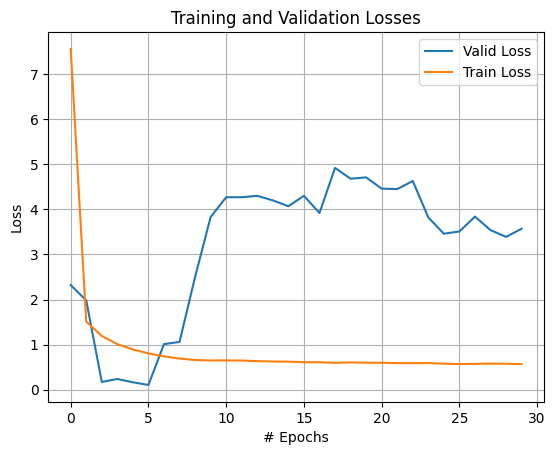

In [ ]:
plot_losses('/content/results/tts/1234/log.txt') # for colab

# plot_losses('C:\\Users\\91730\\Downloads\\convai\\results\\tts\\1234\\log.txt')

## <font color='blue'><b> Train Session 2

In [ ]:
!python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="/content/data/LJSpeech-1.1" hparams.yaml

# !python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="C:\\Users\\91730\\Downloads\\convai\\LJSpeech-1.1" hparams.yaml

speechbrain.core - INFO - Beginning experiment!
speechbrain.core - INFO - Experiment folder: .\\results\\tts\\1234
speechbrain.utils.superpowers - DEBUG - anyio==4.3.0
__main__ - INFO - Preparing datasets...
speechbrain.dataio.encoder - INFO - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - DEBUG - Would load categorical encoding from .\\results\\tts\\1234\\save\phoneme_encoder.txt, but file doesn't exist yet.
speechbrain.dataio.encoder - INFO - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - DEBUG - Loaded categorical encoding from .\\results\\tts\\1234\\save\phoneme_encoder.txt
__main__ - INFO - Datasets prepared.
__main__ - INFO - Starting training...
speechbrain.core - INFO - Info: max_grad_norm arg overridden by command line input to: 

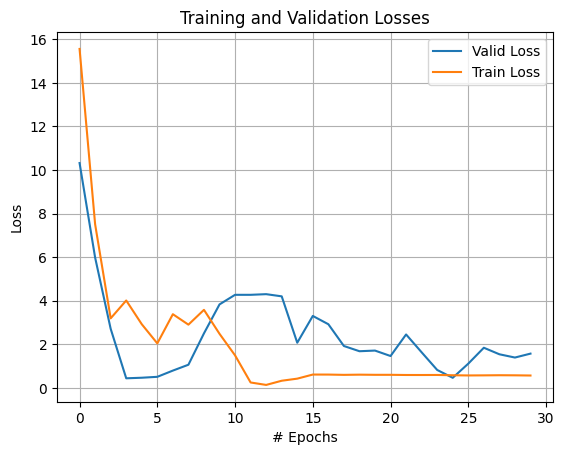

In [ ]:
plot_losses('/content/results/tts/1234/log.txt')

# plot_losses('C:\\Users\\91730\\Downloads\\convai\\results\\tts\\1234\\train_log.txt')

## <font color='blue'><b> Train Session 3

In [ ]:
!python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="/content/data/LJSpeech-1.1" hparams.yaml

# !python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder="C:\\Users\\91730\\Downloads\\convai\\LJSpeech-1.1" hparams.yaml

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: .\\results\\tts\\1234
__main__ - Preparing datasets...
speechbrain.dataio.encoder - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.dataio.encoder - Load called, but TextEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
__main__ - Datasets prepared.
__main__ - Starting training...
speechbrain.core - Info: max_grad_norm arg overridden by command line input to: 1.0
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 18.8M trainable parameters in TTSBrain
speechbrain.utils.fetching - Fetch hyperparams.yaml: Delegating to Huggingface hub, source speechbrain/tts-hifigan-ljspeech.
speechbrain.utils.fetching - HF fetch: C:\Users\91730\.cache\huggingface\hub\models--speechbrain--tts-hifigan-ljspeech\sna

C:\Users\91730\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")

  0%|          | 0/1308 [00:00<?, ?it/s]C:\Users\91730\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
C:\Users\91730\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
C:\Users\91730\AppData\Local\Programs\Python\Python312\Li

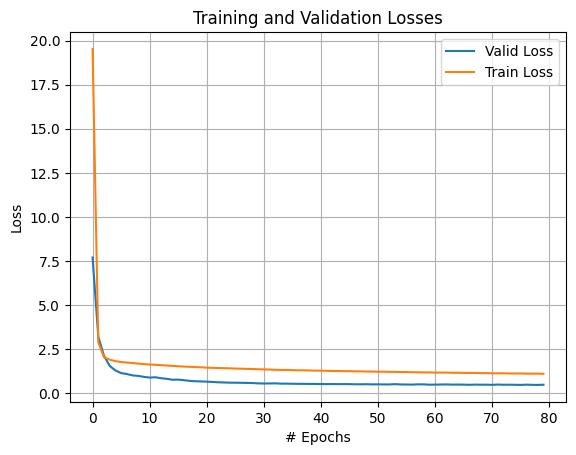

In [ ]:
plot_losses('/content/results/tts/1234/log.txt')

# plot_losses('C:\\Users\\91730\\Downloads\\convai\\results\\tts\\1234\\train_log.txt')

# **References:**

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).

Shen, J., Pang, R., Weiss, R. J., Schuster, M., Jaitly, N., Yang, Z., ... & Wu, Y. (2018). Natural TTS synthesis by conditioning WaveNet on Mel spectrogram predictions. In 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 4779-4783). IEEE.

Ren, J., Rao, K., Weinberger, K. Q., & Wolf, T. (2019). FastSpeech: Fast, robust and controllable text to speech. arXiv preprint arXiv:1905.09263.

Li, Z., Cao, Y., Song, Y., Chen, S., & Lu, H. (2018). Rethinking the Value of Network Pruning. arXiv preprint arXiv:1809.08895.

SpeechBrain is an open-source PyTorch toolkit that accelerates Conversational AI development [link](https://github.com/speechbrain/speechbrain)